### Load Modules

In [ ]:
# Restart the kernel
import os
import dill as pickle
current_dir ='../../../'
os.chdir(current_dir)

from src.codes.basic import *
from src.codes.utils.fem_utils import *
from src.codes.utils.plot_utils import ThreeDPlot as plot
from src.codes.utils.plot_utils import data_stats
from src.codes.utils.rom_utils import *

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM, probdata, ROM_simulation
import src.codes.reductor.rom_class as rom_class
import src.codes.algorithms.deim as deim_module
from importlib import reload
# reload(deim_module)

### Load data

In [2]:
filename_dataC = 'examples/heat_conduction/ThreeD_heat_conduction/data/DataClass.dill'
with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
# train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask

N_snap,_ = np.shape(NLS)
print(N_snap)
eval_rom = False

FileNotFoundError: [Errno 2] No such file or directory: 'examples/heat_conduction/ThreeD_heat_conduction/data/DataClass.dill'

### Plot data

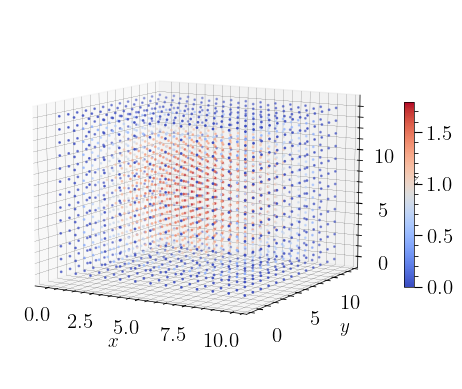

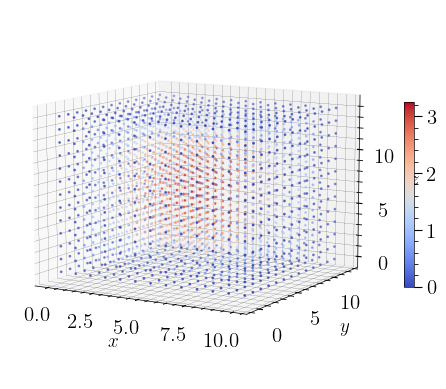

In [3]:
for i in range(2):
    Plot = plot(d.xi[0], d.xi[1], d.xi[2], NLS[i])
    Plot.plot3D()
plt.show()

## DEIM Hyper-reduction

### Train-Test split

In [4]:
train_mask, test_mask = train_test_split(N_snap)

NLS_train = NLS[train_mask]
param_list_train = param_list[train_mask]

NLS_test = NLS[test_mask]


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

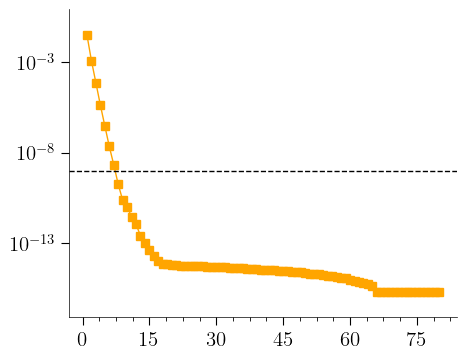

Number of modes selected: 8


In [5]:
# plt.rcParams['figure.dpi'] = 100*2
n_sel, U = svd_mode_selector(NLS_train, tolerance=1e-9,modes=True)
V_sel = U[:, :n_sel]

In [6]:
# for i in range(n_sel):
#     plot(d.xi[0], d.xi[1], V_sel[:,i],elev=15, azim=60).surface_()

### Step 2: Perform SVD on the force snapshots

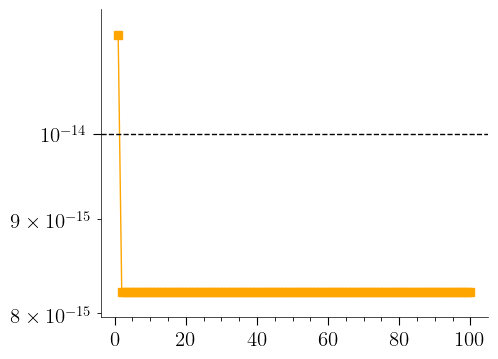

Selected modes:6


In [7]:
# Force snapshots
F_nl = np.asarray(Data_cls.rhs)
deim = deim_module.deim(d,F_nl,train_mask,param_list,V_sel,NLS_train,d.mask,tol_f=1e-14, extra_modes=2)

tic_h_setup_b = time.time()
deim.select_elems()
toc_h_setup_b = time.time()

xi = deim.xi

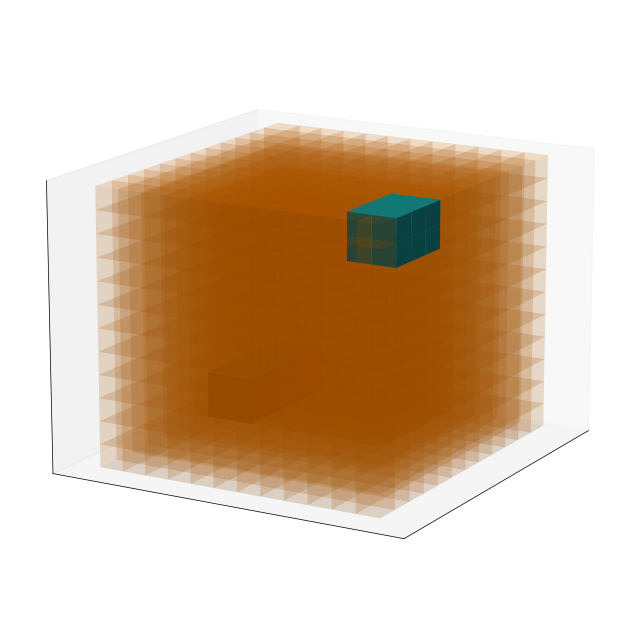

Fraction of total elements active in the ROM: 1.8518518518518519%


In [8]:
plot(0,0,0,0).element3D((d.ncells[0],d.ncells[1],d.ncells[2]), xi, FOS)
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")


### ROM Simulation

In [9]:
ROM_h = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi, deim=deim, N_rom_snap=1,T_init_guess = 2.0)
ROM_h.run_simulation_h_deim();

c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [ ]:
if eval_rom:
    ROM = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi)#, N_rom_snap=1)
    ROM.run_simulation()

### Performance Statistics

In [10]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom)
ROM_speed_up_h = ROM_h.speed_up_h
ROM_relative_error_h = ROM_h.rom_error

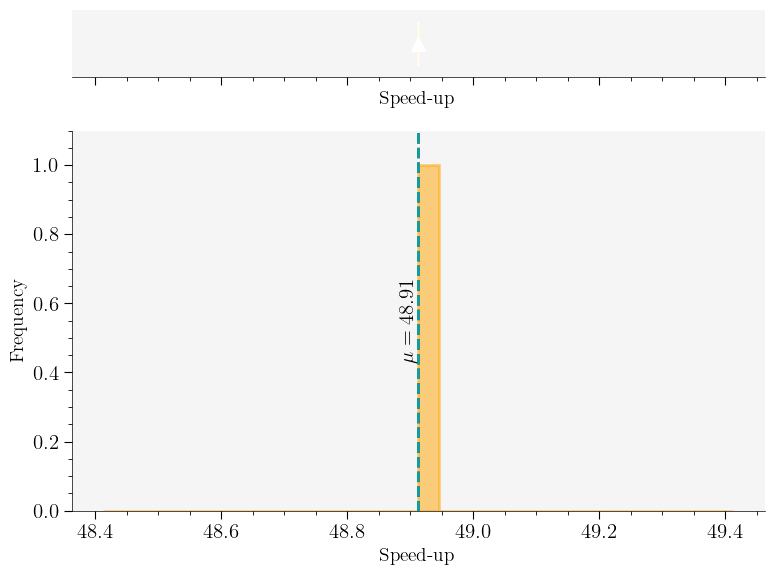

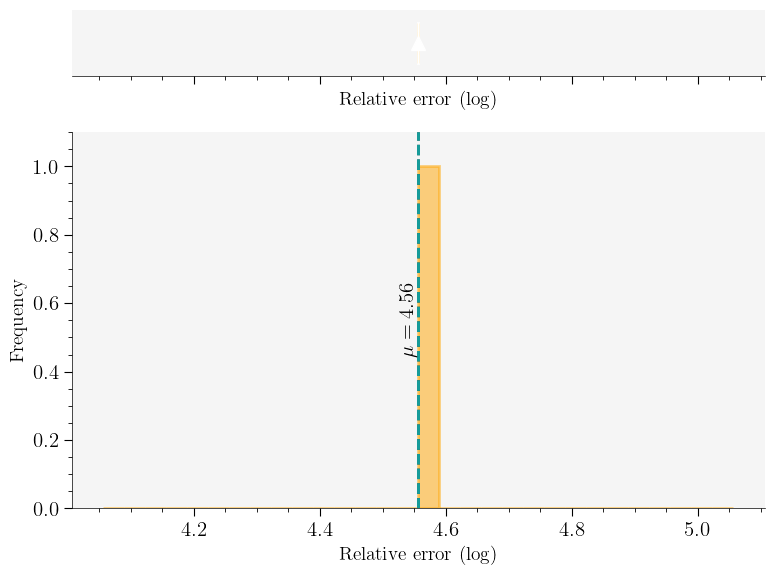

In [11]:
data_stats(ROM_speed_up_h, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
data_stats(np.log10(ROM_relative_error_h), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");

In [23]:
if eval_rom:
    NLS_rom = np.asarray(ROM.NL_solutions_rom)
    ROM_speed_up = ROM.speed_up
    ROM_relative_error = ROM.rom_error

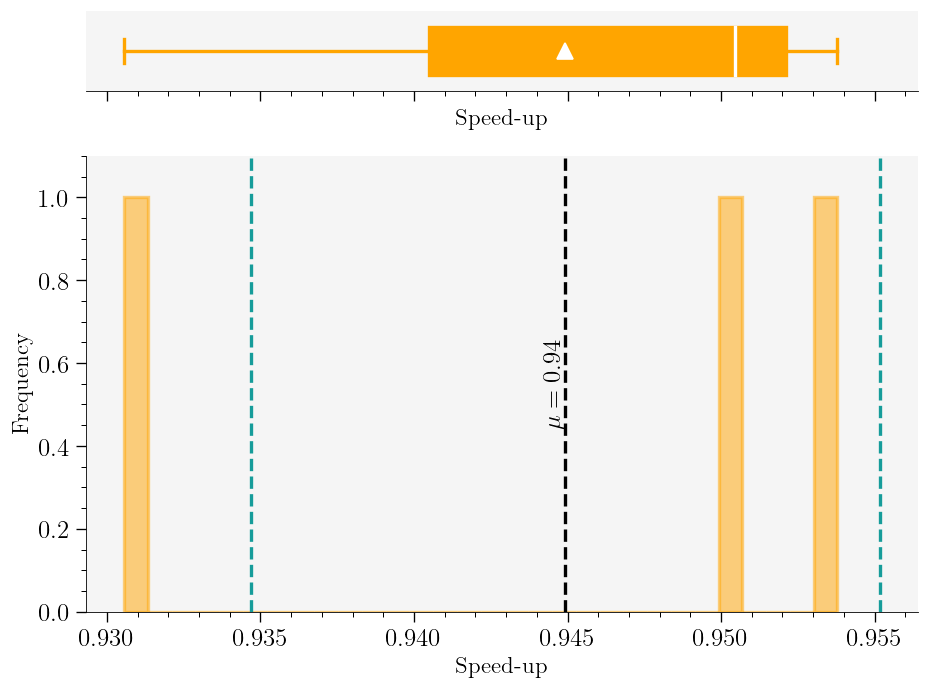

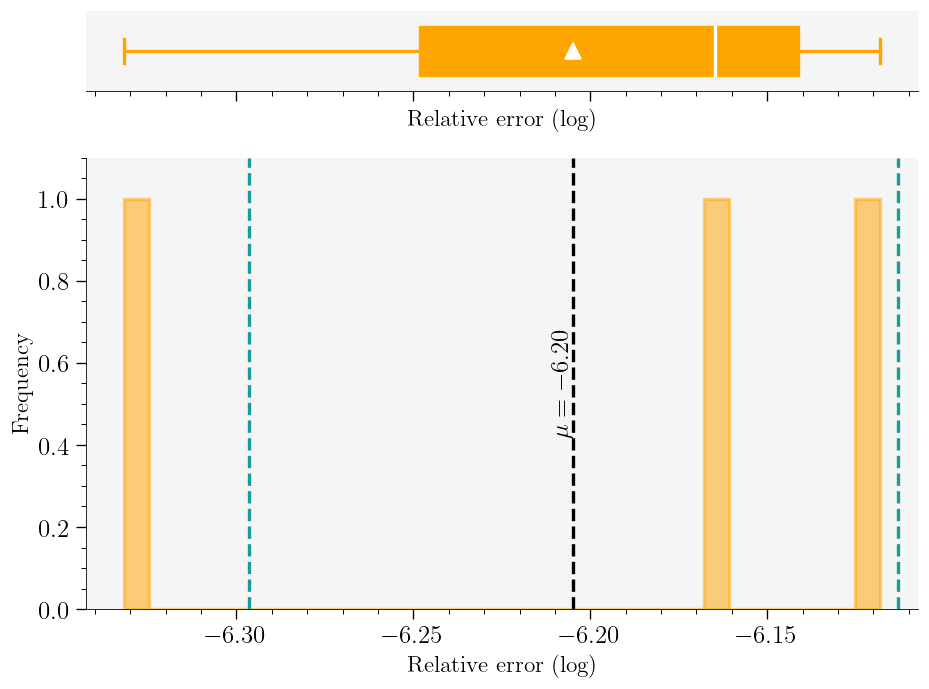

In [24]:
if eval_rom:
    data_stats(ROM_speed_up, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
    data_stats(np.log10(ROM_relative_error), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");